In [37]:
import pandas as pd
from nebulagraph_lite import nebulagraph_let as ng_let
import os, math, torch
from tqdm.notebook import tqdm

from llama_index.core.schema import NodeRelationship, TextNode, RelatedNodeInfo
from llama_index.core.vector_stores import SimpleVectorStore
from llama_index.core.vector_stores.simple import SimpleVectorStoreData, VectorStoreQuery
from llama_index.graph_stores.nebula import NebulaPropertyGraphStore
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from transformers import AutoTokenizer
from llama_index.core import (
    PropertyGraphIndex,
    Settings
)

from typing import Sequence
from llama_index.core.schema import BaseNode, MetadataMode
from llama_index.core.embeddings.utils import resolve_embed_model
from llama_index.core.settings import Settings

In [2]:
# load NebulaGraph JupyterNotebook extension
# !udocker pull vesoft/nebula-metad:v3
# !udocker create --name=nebula-metad vesoft/nebula-metad:v3
# !udocker setup --execmode=F1 nebula-metad
# !udocker pull vesoft/nebula-graphd:v3
# !udocker create --name=nebula-graphd vesoft/nebula-graphd:v3
# !udocker setup --execmode=F1 nebula-graphd
# !udocker pull vesoft/nebula-storaged:v3
# !udocker create --name=nebula-storaged vesoft/nebula-storaged:v3
# !udocker setup --execmode=F1 nebula-storaged

n = ng_let(in_container=True)
n.start() # This takes around 5 mins


Message: Activating storaged...
Result of `SHOW HOSTS`:
    errors:
        code: 0
    results:
        spaceName: 
        data:
            meta:
                None, None, None, None, None, None, None
            row:
                127.0.0.1, 9779, ONLINE, 201, PrimeKG:100, PrimeKG_nebula:100, basketballplayer:1, PrimeKG:100, PrimeKG_nebula:100, basketballplayer:1, 3.8.0
        columns:
            Host, Port, Status, Leader count, Leader distribution, Partition distribution, Version
        errors:
            code: 0
        latencyInUs: 958
Info: loading basketballplayer dataset...

  _   _      _           _        ____                 _     
 | \ | | ___| |__  _   _| | __ _ / ___|_ __ __ _ _ __ | |__  
 |  \| |/ _ | '_ \| | | | |/ _` | |  _| '__/ _` | '_ \| '_ \ 
 | |\  |  __| |_) | |_| | | (_| | |_| | | | (_| | |_) | | | |
 |_| \_|\___|_.__/ \__,_|_|\__,_|\____|_|  \__,_| .__/|_| |_|
                                                |_|          
                           

In [3]:
%reload_ext ngql
%ngql --address 127.0.0.1 --port 9669 --user root --password nebula


[OK] Connection Pool Created


,Name
0,PrimeKG
1,PrimeKG_nebula
2,basketballplayer


# Create the graph from NebulaGraph directly

In [12]:
%ngql CREATE SPACE IF NOT EXISTS PrimeKG_nebula(vid_type=FIXED_STRING(256));
%ngql USE PrimeKG_nebula;

""


In [5]:
#primekg = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/kg.csv", low_memory=False)
nodes = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/nodes.csv",
    low_memory=False,
    sep=',',
    quotechar='"',  
    escapechar='\\', 
)

edges = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/edges.csv")

## Nodes

In [ ]:
print(nodes['node_type'].unique()) #types of nodes

In [6]:
# save the data for each 'node_type' in a separate file
for node_type in nodes['node_type'].unique():
    sanitized_node_type = node_type.replace('/', '_')
    output_path = os.path.join('~/scratch-llm/data/PrimeKG_data/sub_data/', 'node_'+ sanitized_node_type + '.csv')
    nodes[nodes['node_type'] == node_type].to_csv(output_path, index=False)

In [19]:
# Create Tags (node_type) for each node in the PrimeKG
%ngql CREATE TAG IF NOT EXISTS anatomy(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS gene_protein(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS drug(node_name string, node_source string, node_id string, description string, half_life string, indication string, mechanism_of_action string, protein_binding string, pharmacodynamics string, state string, atc_1 string, atc_2 string, atc_3 string, atc_4 string, category string, group string, pathway string, molecular_weight string, tpsa string, clogp string);
%ngql CREATE TAG IF NOT EXISTS disease(node_name string, node_source string, mondo_id int, mondo_name string, group_id_bert string, group_name_bert string, mondo_definition string, umls_description string, orphanet_definition string, orphanet_prevalence string, orphanet_epidemiology string, orphanet_clinical_description string, orphanet_management_and_treatment string, mayo_symptoms string, mayo_causes string, mayo_risk_factors string, mayo_complications string, mayo_prevention string, mayo_see_doc string);
%ngql CREATE TAG IF NOT EXISTS pathway(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS biological_process(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS effect_phenotype(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS molecular_function(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS cellular_component(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS exposure(node_name string, node_source string, node_id string);

""


In [ ]:
# Load each node source data into the corresponding Tag (working fine)
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_gene_protein.csv --tag gene_protein --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_biological_process.csv --tag biological_process --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_effect_phenotype.csv --tag effect_phenotype --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_molecular_function.csv --tag molecular_function --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_cellular_component.csv --tag cellular_component --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_pathway.csv --tag pathway --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_exposure.csv --tag exposure --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_anatomy.csv --tag anatomy --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source


### Extra information for nodes 'drug' and 'disease'

In [ ]:
# disease and drug feature files are available as .tab format so they need to be converted to .csv
# many formatting issues on both files that had to be correcteed manually before merging with the 'node_' dataset
disease_tab = "~/scratch-llm/data/PrimeKG_data/raw_data/disease_features.tab"
drug_tab = "~/scratch-llm/data/PrimeKG_data/raw_data/drug_features.tab"

df = pd.read_csv(disease_tab, delimiter='\t')
disease_csv = "~/scratch-llm/data/PrimeKG_data/sub_data/disease_features.csv"
df.to_csv(disease_csv, index=False)


df = pd.read_csv(drug_tab, delimiter='\t')
drug_csv = "~/scratch-llm/data/PrimeKG_data/sub_data/drug_features.csv"
df.to_csv(drug_csv, index=False) 

In [10]:
# merge extra drug and disease information 
node_drug = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_drug.csv")
features_drug = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/drug_features.csv")
node_disease = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_disease.csv")
features_disease = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/disease_features.csv")


In [37]:
node_disease = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_disease.csv")


In [35]:
features_disease2 = pd.read_csv("~/scratch-llm/data/knowledge_graph/disease_features_fixed.csv")

In [45]:
# the disease_features has multiple rows with the same 'node_index' so we need to merge them
def merge_column_values(column):
    # Check if all values in the column can be converted to float
    try:
        numeric_column = pd.to_numeric(column, errors='coerce')
        if numeric_column.notna().all():  # If all are numbers, return unique values
            return '_'.join(map(str, sorted(set(numeric_column))))  # Keep the first numeric value (assuming they're the same)
    except Exception:
        pass
    
    # For strings, concatenate unique, non-empty values
    return '; '.join(filter(lambda x: pd.notna(x) and str(x).strip() != '', set(column)))

merged_features_disease = features_disease2.groupby('node_index', as_index=False).agg(merge_column_values)

In [46]:
merged_df = pd.merge(node_disease, merged_features_disease, on='node_index')
merged_df.to_csv("~/scratch-llm/data/node_merged_drug2.csv", index=False)

In [ ]:
# Merge the dataframes on 'node_index' and save to csv
merged_df = pd.merge(node_drug, features_drug, on='node_index')
merged_df.to_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_drug.csv", index=False)

merged_df = pd.merge(node_disease, merged_features_disease, on='node_index')
# merged_df.fillna("", inplace=True) # in case included 'extra' diseases that are only present in features_disease
merged_df.to_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_disease.csv", index=False)

In [ ]:
#Load the extended drug and disease data into the corresponding Tags
# NOTE: formatting problems for node_merged_disease.csv
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_disease.csv --tag disease --header --space PrimeKG --batch 50 --vid 0 --props 3:node_name,4:node_source,5:mondo_id,6:mondo_name,7:group_id_bert,8:group_name_bert,9:mondo_definition,10:umls_description,11:orphanet_definition,12:orphanet_prevalence,13:orphanet_epidemiology,14:orphanet_clinical_description,15:orphanet_management_and_treatment,16:mayo_symptoms,17:mayo_causes,18:mayo_risk_factors,19:mayo_complications,20:mayo_prevention,21:mayo_see_doc


loading diseases without extra info:

In [50]:
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_disease.csv --tag disease --header --space PrimeKG --batch 50 --vid 0 --props 3:node_name,4:node_source

[INFO] Parsed 17080 vertices 'PrimeKG' for tag 'disease' in memory


Loading Vertices:   0%|          | 0/342 [00:00<?, ?it/s]

Loaded 50 of 17080 vertices
Loaded 100 of 17080 vertices
Loaded 150 of 17080 vertices
Loaded 200 of 17080 vertices
Loaded 250 of 17080 vertices
Loaded 300 of 17080 vertices
Loaded 350 of 17080 vertices
Loaded 400 of 17080 vertices
Loaded 450 of 17080 vertices
Loaded 500 of 17080 vertices
Loaded 550 of 17080 vertices
Loaded 600 of 17080 vertices
Loaded 650 of 17080 vertices
Loaded 700 of 17080 vertices
Loaded 750 of 17080 vertices
Loaded 800 of 17080 vertices
Loaded 850 of 17080 vertices
Loaded 900 of 17080 vertices
Loaded 950 of 17080 vertices
Loaded 1000 of 17080 vertices
Loaded 1050 of 17080 vertices
Loaded 1100 of 17080 vertices
Loaded 1150 of 17080 vertices
Loaded 1200 of 17080 vertices
Loaded 1250 of 17080 vertices
Loaded 1300 of 17080 vertices
Loaded 1350 of 17080 vertices
Loaded 1400 of 17080 vertices
Loaded 1450 of 17080 vertices
Loaded 1500 of 17080 vertices
Loaded 1550 of 17080 vertices
Loaded 1600 of 17080 vertices
Loaded 1650 of 17080 vertices
Loaded 1700 of 17080 vertices


In [ ]:
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_drug.csv --tag drug --header --space PrimeKG --batch 100 --vid 0 --props 2:node_id,3:node_name,4:node_source,5:description,6:half_life,7:indication,8:mechanism_of_action,9:protein_binding,10:pharmacodynamics,11:state,12:atc_1,13:atc_2,14:atc_3,15:atc_4,16:category,17:group,18:pathway,19:molecular_weight,20:tpsa,21:clogp


In [51]:
%%ngql
MATCH (n:disease) RETURN count(n) as disease_count;

,disease_count
0,17080


## Edges

In [ ]:
print(edges['relation'].unique()) # types of edges

In [8]:
# save the data for each 'relation' (edge type) in a separate file
for relation in edges['relation'].unique():
    sanitized_relation = relation.replace('-', '_')
    sanitized_relation = sanitized_relation.replace('\t', '_')
    output_path = os.path.join('~/scratch-llm/data/PrimeKG_data/sub_data/', 'edge_'+ sanitized_relation + '.csv')
    edges[edges['relation'] == relation].to_csv(output_path, index=False)

In [52]:
%ngql CREATE EDGE IF NOT EXISTS protein_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS contraindication(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS indication(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS off_label_use(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_drug(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS phenotype_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS phenotype_phenotype(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_phenotype_negative(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_phenotype_positive(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_disease(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_effect(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS bioprocess_bioprocess(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS molfunc_molfunc(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS cellcomp_cellcomp(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS molfunc_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS cellcomp_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS bioprocess_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_disease(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_exposure(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_bioprocess(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_molfunc(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_cellcomp(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS pathway_pathway(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS pathway_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_anatomy(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_protein_present(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_protein_absent(display_relation string);

""


In [ ]:
# for each edge type, load the data accordingly, this takes like 20mins from new
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_protein_protein.csv --space PrimeKG --batch 100 --header --edge protein_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_protein.csv --space PrimeKG --header --batch 100 --edge drug_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_contraindication.csv --space PrimeKG --header --batch 100 --edge contraindication --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_indication.csv --space PrimeKG --header --batch 100 --edge indication --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_off_label_use.csv --space PrimeKG --header --batch 100 --edge off_label_use --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_drug.csv --space PrimeKG --header --batch 100 --edge drug_drug --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_phenotype_protein.csv --space PrimeKG --header --batch 100 --edge phenotype_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_phenotype_phenotype.csv --space PrimeKG --header --batch 100 --edge phenotype_phenotype --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_phenotype_negative.csv --space PrimeKG --header --batch 100 --edge disease_phenotype_negative --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_phenotype_positive.csv --space PrimeKG --header --batch 100 --edge disease_phenotype_positive --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_protein.csv --space PrimeKG --header --batch 100 --edge disease_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_disease.csv --space PrimeKG --header --batch 100 --edge disease_disease --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_effect.csv --space PrimeKG --header --batch 100 --edge drug_effect --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_bioprocess_bioprocess.csv --space PrimeKG --header --batch 100 --edge bioprocess_bioprocess --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_molfunc_molfunc.csv --space PrimeKG --header --batch 100 --edge molfunc_molfunc --src 2 --dst 3 --props 1:display_relation


In [ ]:
# load the edge data in two batches
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_cellcomp_cellcomp.csv --space PrimeKG --header --batch 100 --edge cellcomp_cellcomp --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_molfunc_protein.csv --space PrimeKG --header --batch 100 --edge molfunc_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_cellcomp_protein.csv --space PrimeKG --header --batch 100 --edge cellcomp_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_bioprocess_protein.csv --space PrimeKG --header --batch 100 --edge bioprocess_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_protein.csv --space PrimeKG --header --batch 100 --edge exposure_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_disease.csv --space PrimeKG --header --batch 100 --edge exposure_disease --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_exposure.csv --space PrimeKG --header --batch 100 --edge exposure_exposure --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_bioprocess.csv --space PrimeKG --header --batch 100 --edge exposure_bioprocess --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_molfunc.csv --space PrimeKG --header --batch 100 --edge exposure_molfunc --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_cellcomp.csv --space PrimeKG --header --batch 100 --edge exposure_cellcomp --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_pathway_pathway.csv --space PrimeKG --header --batch 100 --edge pathway_pathway --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_pathway_protein.csv --space PrimeKG --header --batch 100 --edge pathway_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_anatomy.csv --space PrimeKG --header --batch 100 --edge anatomy_anatomy --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_protein_present.csv --space PrimeKG --batch 100 --header --edge anatomy_protein_present --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_protein_absent.csv --space PrimeKG --header --batch 100 --edge anatomy_protein_absent --src 2 --dst 3 --props 1:display_relation


In [95]:
%%ng_draw
MATCH (e:Node__)
WHERE id(e) == "33305"
MATCH (e)-[r1:Relation__]-(t1)

RETURN DISTINCT 
        e.Props__.node_name, 
        # e.Chunk__.text
        r1.label,
        id(t1),
        t1.Props__.node_name


<class 'pyvis.network.Network'> |N|=0 |E|=0

# Load directly to NebulaPropertyGraphStore

define files to use:

In [5]:
data_dir = '~/scratch-llm/data/PrimeKG_data/sub_data/'

# List of node types and their corresponding CSV files
node_files = {
    'node_gene_protein.csv',
    'node_merged_drug.csv', # manually corrected and generated from "extra information section"
    'node_effect_phenotype.csv',
    'node_merged_disease.csv', # manually corrected and generated from "extra information section"
    'node_biological_process.csv',
    'node_molecular_function.csv',
    'node_cellular_component.csv',
    'node_exposure.csv',
    'node_pathway.csv',
    'node_anatomy.csv'
}

edge_files ={
    'edge_protein_protein.csv',
    'edge_drug_protein.csv',
    'edge_contraindication.csv',
    'edge_indication.csv',
    'edge_off_label_use.csv',
    'edge_drug_drug.csv',
    'edge_phenotype_protein.csv',
    'edge_phenotype_phenotype.csv',
    'edge_disease_phenotype_negative.csv',
    'edge_disease_phenotype_positive.csv',
    'edge_disease_protein.csv',
    'edge_disease_disease.csv',
    'edge_drug_effect.csv',
    'edge_bioprocess_bioprocess.csv',
    'edge_molfunc_molfunc.csv',
    'edge_cellcomp_cellcomp.csv',
    'edge_molfunc_protein.csv',
    'edge_cellcomp_protein.csv',
    'edge_bioprocess_protein.csv',
    'edge_exposure_protein.csv',
    'edge_exposure_disease.csv',
    'edge_exposure_exposure.csv',
    'edge_exposure_bioprocess.csv',
    'edge_exposure_molfunc.csv',
    'edge_exposure_cellcomp.csv',
    'edge_pathway_pathway.csv',
    'edge_pathway_protein.csv',
    'edge_anatomy_anatomy.csv',
    'edge_anatomy_protein_present.csv',
    'edge_anatomy_protein_absent.csv'
}

## Nodes

### create TextNodes:

In [ ]:
# create TextNodes
def create_text_nodes(file_path):
    df = pd.read_csv(file_path)
    text_nodes = []
    for _, row in df.iterrows():
        id = row['node_index']
        if len(row) > 5: # longer text info (drug/disease)
            metadata_columns = ['node_index', 'node_id', 'node_type', 'node_name', 
                            'node_source', 'mondo_id', 'mondo_name', 'group_id_bert', 
                            'group_name_bert', 'orphanet_prevalence']
            
            text_columns = ['mondo_definition', 'umls_description', 'orphanet_definition', 
                        'orphanet_clinical_description', 'orphanet_management_and_treatment','orphanet_epidemiology', 
                        'mayo_symptoms', 'mayo_causes', 'mayo_risk_factors', 'mayo_complications',
                        'mayo_prevention', 'mayo_see_doc','description', 'indication', 'mechanism_of_action',
                        'half_life', 'protein_binding', 'pharmacodynamics', 'state', 'atc_1', 'atc_2', 'atc_3', 
                        'atc_4', 'category', 'group', 'pathway', 'molecular_weight', 'tpsa', 'clogp'] 
            available_metadata_columns = [col for col in metadata_columns if col in df.columns]
            available_text_columns = [col for col in text_columns if col in df.columns] 

            # Extract metadata, not including empty entries     
            metadata = {
                col: row[col] for col in available_metadata_columns
                if col in row and not (isinstance(row[col], float) and math.isnan(row[col]))
            }
            metadata = {k: str(v) for k, v in metadata.items()} #ensure entries are strings

            # Extract and concatenate text values, not including empty entries
            text_entries = [str(row[col]) for col in available_text_columns if pd.notna(row[col])]
            text = "\n".join(text_entries)            

            text_node = TextNode(id_= str(id), text=text, metadata=metadata)
            text_nodes.append(text_node)

        else: # no text data, all other files
            metadata = row.to_dict()
            metadata = {k: str(v) for k, v in metadata.items()} #ensure entries are strings
            text_node = TextNode(id_= str(id), metadata=metadata)
            text_nodes.append(text_node)

    return text_nodes

# generate all nodes from the node files
all_nodes = []
for file in node_files:
    nodes = create_text_nodes(data_dir+file)
    all_nodes.extend(nodes)


### create Entity and ChunkNodes:

In [18]:
# Convert TextNode objects to the format expected by NebulaPropertyGraphStore
from llama_index.core.graph_stores.types import EntityNode, ChunkNode
all_entity_nodes = []

def create_entity_nodes(file_path, label):
    df = pd.read_csv(file_path)
    nodes = []
    for _, row in df.iterrows():
        text=None
        id = row['node_index']
        metadata_columns = ['node_index', 'node_id', 'node_type', 'node_name', 
                            'node_source', 'mondo_id', 'mondo_name', 'group_id_bert', 
                            'group_name_bert', 'orphanet_prevalence']
        
        text_columns = ['mondo_definition', 'umls_description', 'orphanet_definition', 
                        'orphanet_clinical_description', 'orphanet_management_and_treatment','orphanet_epidemiology', 
                        'mayo_symptoms', 'mayo_causes', 'mayo_risk_factors', 'mayo_complications',
                        'mayo_prevention', 'mayo_see_doc','description', 'indication', 'mechanism_of_action',
                        'half_life', 'protein_binding', 'pharmacodynamics', 'state', 'atc_1', 'atc_2', 'atc_3', 
                        'atc_4', 'category', 'group', 'pathway', 'molecular_weight', 'tpsa', 'clogp'] 
        available_metadata_columns = [col for col in metadata_columns if col in df.columns]
        available_text_columns = [col for col in text_columns if col in df.columns] 

        # Extract metadata, not including empty entries     
        metadata = {
            col: row[col] for col in available_metadata_columns
            if col in row and not (isinstance(row[col], float) and math.isnan(row[col]))
        }
        metadata = {k: str(v) for k, v in metadata.items()}  # ensure entries are strings

        # Extract and concatenate text values, not including empty entries
        text_entries = [str(row[col]) for col in available_text_columns if pd.notna(row[col])]
        text = " ".join(text_entries)            

        if text is not None:  # if there is text data, create a ChunkNode
            node = ChunkNode(id_=str(id), label=label, properties=metadata, text=text)
        else:  # if there is no text data, empty ChunkNode
            node = ChunkNode(id_=str(id), label=label, properties=metadata, text='')
        
        nodes.append(node)

    return nodes


In [15]:
for file in node_files:
    # remove 'node_' and '.csv' and merged_ from the label
    label = file.replace('node_', '').replace('.csv', '').replace('merged_', '')
    nodes = create_entity_nodes(data_dir + file, label)
    all_entity_nodes.extend(nodes)
    

In [17]:
#save to pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_entity_nodes.pkl'), 'wb') as f:
    pickle.dump(all_entity_nodes, f)

In [42]:
#load from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_entity_nodes.pkl'), 'rb') as f:
    all_entity_nodes = pickle.load(f)

## Edges

### append edges to TextNodes:

In [50]:
# create all edges
from tqdm.notebook import tqdm

def create_all_edges(file_path, all_nodes):
    node_dict = {node.id_: node for node in all_nodes} #speed up search
    df = pd.read_csv(os.path.join(file_path))

    for _, row in tqdm(df.iterrows(), total=len(df), leave=False, desc=f"Processing {file_path}"):
        x_index = str(row['x_index'])
        y_index = str(row['y_index'])
        
        if x_index in node_dict:
            origin_node = node_dict[x_index]
            if NodeRelationship.CHILD not in origin_node.relationships:
                origin_node.relationships[NodeRelationship.CHILD] = []
           
            metadata = row.drop(['x_index', 'y_index']).to_dict()
            new_relationship = RelatedNodeInfo(node_id=y_index, metadata=metadata)
            origin_node.relationships[NodeRelationship.CHILD].append(new_relationship)


In [ ]:
# all relationships for all nodes, takes around 20 mins
for file in tqdm(edge_files, desc='Procesing edge files'):
    create_all_edges(data_dir+file, all_nodes)

save/load nodes-relationships to pickle

In [51]:
# save `all_nodes` with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes.pkl'), 'wb') as f:
    pickle.dump(all_nodes, f)

In [3]:
# load from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes.pkl'), 'rb') as f:
    all_nodes = pickle.load(f)
    

### create Relations for Entity/ChunkNodes:

In [ ]:
from llama_index.core.graph_stores.types import Relation
from tqdm.notebook import tqdm

def create_realtions(file_path, label):
    df = pd.read_csv(file_path)
    relations = []
    for _, row in tqdm(df.iterrows(), total=len(df), leave=False, desc=f"Processing {file_path}"):
        start_node = row['x_index']
        end_node = row['y_index']
        properties = row.drop(['relation']).to_dict()
        properties = row.drop(['relation', 'x_index', 'y_index']).to_dict()
        relation = Relation(source_id=str(start_node), target_id=str(end_node), label=label, properties=properties)
        relations.append(relation)
    return relations



In [ ]:
all_relations = [] 
for file in tqdm(edge_files, desc='Procesing edge files'): #35 mins
    relations = create_realtions(data_dir+file, file[5:-4].replace('_', '-'))
    all_relations.extend(relations)

In [54]:
#save relations with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_relations.pkl'), 'wb') as f:
    pickle.dump(all_relations, f)


In [3]:
#load relations with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_relations.pkl'), 'rb') as f:
    all_relations = pickle.load(f)

# Generate node embeddings manually

### Load tokenizer and model

tokenizer and model:

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load tokenizer and set pad_token_id explicitly
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B")

if tokenizer.pad_token_id is None: #no <pad> token previously defined, only eos_token
    tokenizer.pad_token = "<|end_of_text|>"
    tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=256,
    generate_kwargs={
        "temperature": 0.8, 
        "do_sample": True,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id},
    tokenizer=tokenizer,
    model_name="meta-llama/Llama-3.2-3B",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    stopping_ids=[50278, 50279, 50277, 1, 0],
    tokenizer_kwargs={"max_length": 4096},
    # uncomment this if using CUDA to reduce memory usage
    model_kwargs={"torch_dtype": torch.float16},
)

Settings.llm = llm
Settings.chunk_size = 1024

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
Settings.embed_model = HuggingFaceEmbedding(model_name='BAAI/bge-m3') # BAAI/bge-small-en-v1.5

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

## Embeddings for TextNodes:

In [ ]:

def embed_nodes(nodes: Sequence[BaseNode], embed_model=None, use_async=True, show_progress=False) -> Sequence[BaseNode]:
    """Embed nodes with specified embedding model."""
    if embed_model is None:
        embed_model = Settings.embed_model  # Use default embed model from settings

    embed_model = resolve_embed_model(embed_model)

    node_texts = []
    for node in nodes:
        node_text = node.metadata["node_name"]        
        node_text += f" ({node.metadata['node_type']})"
        
        # Add text content if it exists
        content = node.get_content(metadata_mode=MetadataMode.NONE)
        if content and content.strip():
            import re
            cleaned_content = re.sub(r'\n+', ' ', content)
            node_text += f": {cleaned_content}"
        
        node_texts.append(node_text)
    print(f"Number of nodes {len(nodes)}")
    print(f"Embedding {len(node_texts)} nodes")

    if use_async:
        embeddings = embed_model.aget_text_embedding_batch(node_texts, show_progress=show_progress)
    else:
        embeddings = embed_model.get_text_embedding_batch(node_texts, show_progress=show_progress)

    for node, embedding in zip(nodes, embeddings):
        node.embedding = embedding

    return nodes

## generate embeddings for TextNodes
all_nodes_embedded = embed_nodes(all_nodes, use_async=False, show_progress=True) #takes 15 mins for all_nodes


Number of nodes 10
Embedding 10 nodes


Generating embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def embed_nodes(nodes: Sequence[BaseNode], embed_model=None, use_async=True, show_progress=False) -> Sequence[BaseNode]:
    """Embed nodes with specified embedding model."""
    if embed_model is None:
        embed_model = Settings.embed_model  # Use default embed model from settings

    embed_model = resolve_embed_model(embed_model)

    node_texts = []
    for node in nodes:
        # Create a list to hold the formatted fields
        fields = []

        fields.append(f"node_name: {node.metadata['node_name']}")
        fields.append(f"node_type: {node.metadata['node_type']}")
                
        if "mondo_name" in node.metadata:
            fields.append(f"mondo_name: {node.metadata['mondo_name']}")
        if "group_name_bert" in node.metadata:
            fields.append(f"group_name_bert: {node.metadata['group_name_bert']}")
        
        content = node.get_content(metadata_mode=MetadataMode.NONE)
        if content:
            fields.append("")
            fields.append(content)    
        
        # Join all fields with newlines
        node_text = "\n".join(fields)
        node_texts.append(node_text)
    
    print(f"Number of nodes {len(nodes)}")
    print(f"Embedding {len(node_texts)} nodes")

    if use_async:
        embeddings = embed_model.aget_text_embedding_batch(node_texts, show_progress=show_progress)
    else:
        embeddings = embed_model.get_text_embedding_batch(node_texts, show_progress=show_progress)

    for node, embedding in zip(nodes, embeddings):
        node.embedding = embedding

    return nodes

## generate embeddings for TextNodes
all_nodes_embedded = embed_nodes(all_nodes, use_async=False, show_progress=True)


Number of nodes 10
Embedding 10 nodes


Generating embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# save `all_nodes_embedded` with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_embedded.pkl'), 'wb') as f:
    pickle.dump(all_nodes_embedded, f)
    

In [8]:
# load all_nodes_embedded from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_embedded.pkl'), 'rb') as f:
    all_nodes_embedded = pickle.load(f)

## embeddings for Entity/ChunkNodes:

In [ ]:

# Helper function to get content from EntityNode
def get_entity_node_content(node: EntityNode) -> str:
    # Concatenate all property values to form the content
    return " ".join(str(value) for value in node.properties.values())

# Modified embed_nodes function to handle EntityNode objects
def embed_entity_nodes(nodes: Sequence[EntityNode], embed_model=None, use_async=True, show_progress=False) -> Sequence[EntityNode]:
    """Embed EntityNode objects with specified embedding model."""
    if embed_model is None:
        embed_model = Settings.embed_model  # Use default embed model from settings

    embed_model = resolve_embed_model(embed_model)
    node_texts = [get_entity_node_content(node) for node in nodes]

    if use_async:
        embeddings = embed_model.aget_text_embedding_batch(node_texts, show_progress=show_progress)
    else:
        embeddings = embed_model.get_text_embedding_batch(node_texts, show_progress=show_progress)

    for node, embedding in zip(nodes, embeddings):
        node.embedding = embedding

    return nodes

# Generate embeddings for all EntityNode objects
entity_nodes_embedded = embed_entity_nodes(all_entity_nodes, use_async=False, show_progress=True)

In [ ]:
#save entity_nodes_embedded with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/nodes/entity_nodes_embedded.pkl'), 'wb') as f:
    pickle.dump(entity_nodes_embedded, f)

In [20]:
#load entity_nodes_embedded from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/nodes/entity_nodes_embedded.pkl'), 'rb') as f:
    entity_nodes_embedded = pickle.load(f)

# Vector + Graph store:

SimpleVectorStore + NebulaPropertyGraphStore:

In [ ]:
import pickle
from typing import List

# Load the actual data into all_nodes_embeddded
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes_embedded.pkl'), 'rb') as f:
    all_nodes_embedded: List[TextNode] = pickle.load(f)


# Create dictionaries from the nodes
embedding_dict = {node.id_: node.get_embedding() for node in all_nodes_embedded}
text_id_to_ref_doc_id = {node.id_: node.ref_doc_id or "None" for node in all_nodes_embedded}
metadata_dict = {node.id_: node.metadata for node in all_nodes_embedded}

# Initialize the SimpleVectorStore with the dictionaries
vector_store = SimpleVectorStore(
    data = SimpleVectorStoreData(
        embedding_dict=embedding_dict,
        text_id_to_ref_doc_id=text_id_to_ref_doc_id,
        metadata_dict=metadata_dict,
    ),
    stores_text=True
)

# PropertyGraphIndex requires NebulaPropertyGraphStore
graph_store = NebulaPropertyGraphStore(
    space= "PrimeKG", 
    username = "root",
    password = "nebula",
    url = "nebula://localhost:9669",
    props_schema= "`node_index` STRING, `node_type` STRING, `node_id` STRING, `node_name` STRING, `node_source` STRING, `mondo_id` STRING, `mondo_name` STRING, `group_id_bert` STRING, `group_name_bert` STRING, `orphanet_prevalence` STRING, `umls_description` STRING, `orphanet_definition` STRING, `orphanet_epidemiology` STRING, `orphanet_clinical_description` STRING, `orphanet_management_and_treatment` STRING, `mayo_symptoms` STRING, `mayo_causes` STRING, `mayo_risk_factors` STRING, `mayo_complications` STRING, `mayo_prevention` STRING, `mayo_see_doc` STRING, `display_relation` STRING, `_node_content` STRING, `_node_type` STRING, `document_id` STRING, `doc_id` STRING, `ref_doc_id` STRING, `triplet_source_id` STRING",
)


upsert Entity/ChunkNodes (nodes) and Relations (edges) into the NebulaPropertyGraphStore:

In [ ]:
# Ensure all node_id values are strings
for node in all_entity_nodes:
    node.properties['node_id'] = str(node.properties['node_id'])

# Upsert all nodes to the graph store in batches of 1000, there is no batch_size parameter, 4 mins
for i in tqdm(range(0, len(all_entity_nodes), 1000), desc='Upserting nodes'):
    batch = all_entity_nodes[i:i+1000]
    graph_store.upsert_nodes(batch)


In [14]:
#upsert edges for all nodes, 70 mins
for i in tqdm(range(0, len(all_relations), 1000), desc='Upserting edges'):
    batch = all_relations[i:i+1000]
    graph_store.upsert_relations(batch)


Upserting edges:   0%|          | 0/8101 [00:00<?, ?it/s]

test vector store:

In [16]:
# 2. Create a VectorStoreQuery
# Generate the query embedding using the embedding model
query_text = "lymphatic"  # Replace with your actual query text
query_embedding = Settings.embed_model.get_text_embedding(query_text)

vector_store_query = VectorStoreQuery(
    query_embedding=query_embedding,
    similarity_top_k=3,
)

# 3. Query the vector store
results = vector_store.query(vector_store_query)

# 4. Process the results
print("Query Results:")
for node_id, similarity in zip(results.ids, results.similarities):
    print(f"Node ID: {node_id}, Similarity: {similarity}")

Query Results:
Node ID: 38538, Similarity: 0.7625146071800035
Node ID: 35769, Similarity: 0.7581816272086574
Node ID: 28185, Similarity: 0.7351653170212283


# Evaluate embeddings generated

## MTEB embedding model evaluation

In [1]:
from mteb import MTEB
import mteb
from sentence_transformers import SentenceTransformer


In [ ]:

model_name = {"BAAI/bge-small-en-v1.5",
              "all-mpnet-base-v2",
                "BAAI/bge-m3",
                "all-MiniLM-L6-v2",  
                "all-MiniLM-L12-v2"}
tasks  = mteb.get_tasks(task_types=["Retrieval"], languages=["eng"], domains=["Medical"]) # tasks=["MedicalQARetrieval", "PublicHealthQA"]
evaluation = MTEB(tasks)


In [ ]:

model = SentenceTransformer(model_name)

# results = evaluation.run(model, output_folder=os.path.expanduser(f"~/scratch-llm/results/MTEB/{model_name}"))
results = evaluation.run(model, output_folder=f"results/{model_name}")

In [34]:
tasks

MTEBTasks(ArguAna(name='ArguAna', languages=['eng']), FeedbackQARetrieval(name='FeedbackQARetrieval', languages=['eng']), MedicalQARetrieval(name='MedicalQARetrieval', languages=['eng']), MSMARCO(name='MSMARCO', languages=['eng']), MSMARCOHardNegatives(name='MSMARCOHardNegatives', languages=['eng']), MSMARCOv2(name='MSMARCOv2', languages=['eng']), NanoArguAnaRetrieval(name='NanoArguAnaRetrieval', languages=['eng']), NanoNFCorpusRetrieval(name='NanoNFCorpusRetrieval', languages=['eng']), NanoSciFactRetrieval(name='NanoSciFactRetrieval', languages=['eng']), NFCorpus(name='NFCorpus', languages=['eng']), SciFact(name='SciFact', languages=['eng']), TRECCOVID(name='TRECCOVID', languages=['eng']), CUREv1Retrieval(name='CUREv1', languages=['eng', 'fra', 'spa']), PublicHealthQARetrieval(name='PublicHealthQA', languages=['eng']))

In [12]:
for name in model_name:
    model = SentenceTransformer(name)
    evaluation = MTEB(tasks)
    results = evaluation.run(model, output_folder=f"results/{name}")


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- MedicalQARetrieval, s2s

- PublicHealthQA, s2p, multilingual 1 / 8 Subsets

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- MedicalQARetrieval, s2s

- PublicHealthQA, s2p, multilingual 1 / 8 Subsets

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- MedicalQARetrieval, s2s

- PublicHealthQA, s2p, multilingual 1 / 8 Subsets

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- MedicalQARetrieval, s2s

- PublicHealthQA, s2p, multilingual 1 / 8 Subsets

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- MedicalQARetrieval, s2s

- PublicHealthQA, s2p, multilingual 1 / 8 Subsets

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
import json
import glob

# Define the path to the JSON files
json_files = glob.glob("/home/lasa14/project-llm/git-llm-rag/results/**/*.json", recursive=True)

# Iterate through each file and extract the "main_score"
for file in json_files:
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            main_score = data.get("scores", {}).get("test", [{}])[0].get("main_score", None)
            if main_score is not None:
                print(f"File: {file}")
                print(f"Main Score: {main_score}\n")
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {file}")

File: /home/lasa14/project-llm/git-llm-rag/results/all-mpnet-base-v2/sentence-transformers__all-mpnet-base-v2/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0/MedicalQARetrieval.json
Main Score: 0.66517

File: /home/lasa14/project-llm/git-llm-rag/results/all-mpnet-base-v2/sentence-transformers__all-mpnet-base-v2/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0/PublicHealthQA.json
Main Score: 0.81024

File: /home/lasa14/project-llm/git-llm-rag/results/BAAI/bge-small-en-v1.5/BAAI__bge-small-en-v1.5/5c38ec7c405ec4b44b94cc5a9bb96e735b38267a/MedicalQARetrieval.json
Main Score: 0.65558

File: /home/lasa14/project-llm/git-llm-rag/results/BAAI/bge-small-en-v1.5/BAAI__bge-small-en-v1.5/5c38ec7c405ec4b44b94cc5a9bb96e735b38267a/PublicHealthQA.json
Main Score: 0.76177

File: /home/lasa14/project-llm/git-llm-rag/results/BAAI/bge-m3/BAAI__bge-m3/5617a9f61b028005a4858fdac845db406aefb181/MedicalQARetrieval.json
Main Score: 0.68098

File: /home/lasa14/project-llm/git-llm-rag/results/BAAI/bge-m3/BAAI__bge-m3/5617a9f61b

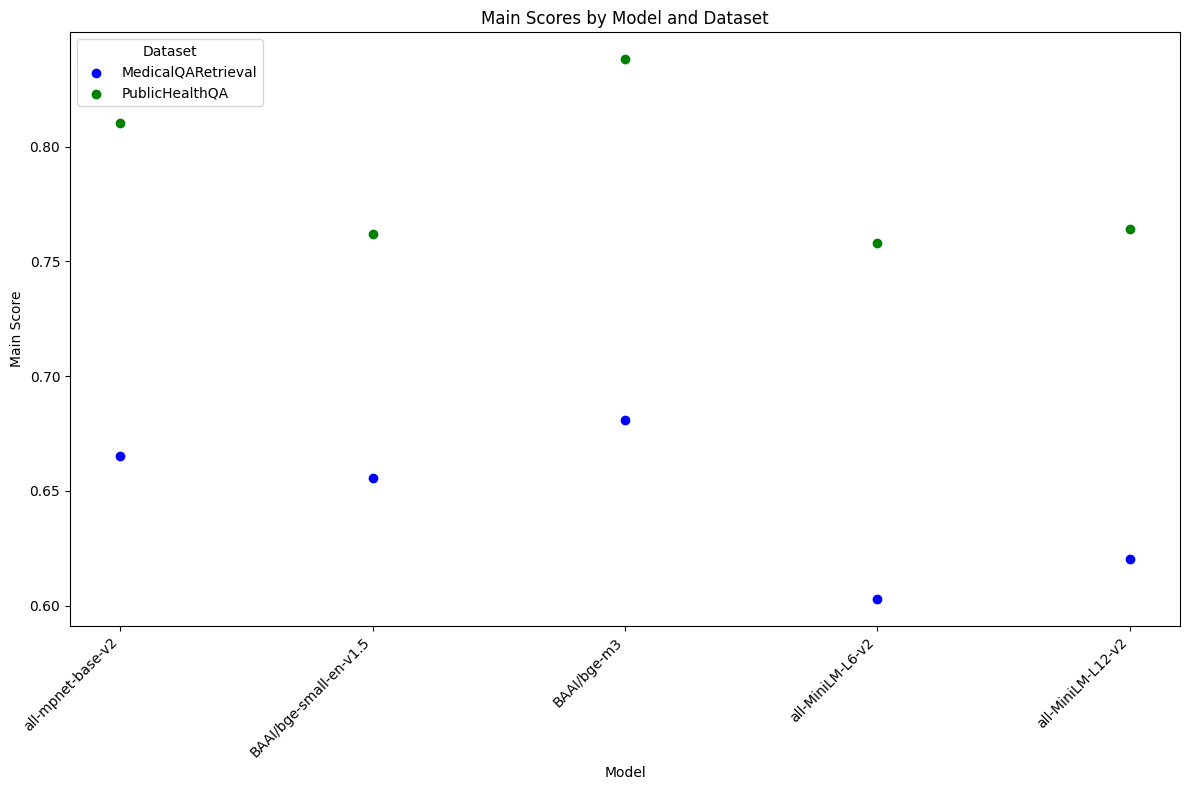

In [31]:
# ...existing code...

# Prepare data for plotting
colors = ["blue", "green"]  # Assign colors for datasets
dataset_names = list(set(dataset for scores in model_scores.values() for dataset in scores.keys()))
dataset_colors = {dataset: colors[i % len(colors)] for i, dataset in enumerate(dataset_names)}

plt.figure(figsize=(12, 8))

# Track datasets added to the legend
added_to_legend = set()

for model_name, datasets in model_scores.items():
    for dataset_name, scores in datasets.items():
        plt.scatter(
            [model_name] * len(scores),
            scores,
            color=dataset_colors[dataset_name],
            label=dataset_name if dataset_name not in added_to_legend else None
        )
        added_to_legend.add(dataset_name)

# Add labels and legend
plt.xlabel("Model")
plt.ylabel("Main Score")
plt.title("Main Scores by Model and Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(title="Dataset", loc="upper left")
plt.show()

## Generate subgraph

In [35]:
#import nodes from pickle from the storage
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_embedded_mpnet_base_v2.pkl'), 'rb') as f:
    all_nodes_embedded = pickle.load(f)


In [93]:
from collections import defaultdict
from tqdm.notebook import tqdm  # Import tqdm for progress bar

# Create a dictionary to map node IDs to nodes for faster lookup
node_dict = {node.node_id: node for node in all_nodes_embedded}

# Create a dictionary to track connections between node types
node_type_connections = defaultdict(set)

# Iterate through all nodes and their relationships with a progress bar
for node in tqdm(all_nodes_embedded, desc="Processing nodes"):
    for rel in node.relationships.get(NodeRelationship.CHILD, []):
        target_node = node_dict.get(rel.node_id)  # Use dictionary lookup instead of searching the list
        if target_node:
            target_node_type = target_node.metadata.get('node_type', 'unknown')
            node_type_connections[node.node_id].add(target_node_type)

# Find all nodes connected to at least 4 different types
def find_nodes_with_four_types(node_type_connections):
    nodes_with_four_types = []
    for node_id, connected_types in node_type_connections.items():
        if len(connected_types) >= 10:
            nodes_with_four_types.append((node_id, connected_types))
    return nodes_with_four_types

nodes_with_four_types = find_nodes_with_four_types(node_type_connections)

# Store the nodes with at least 4 different types
if nodes_with_four_types:
    print(f"Found {len(nodes_with_four_types)} nodes with connections to at least 4 different types.")
    for node_id, connected_types in nodes_with_four_types:
        print(f"Node ID: {node_id}, Connected Types: {connected_types}")
else:
    print("No nodes found with connections to at least 4 different types.")

Processing nodes:   0%|          | 0/129375 [00:00<?, ?it/s]

Found 117 nodes with connections to at least 4 different types.
Node ID: 33, Connected Types: {'anatomy', 'biological_process', 'molecular_function', 'pathway', 'exposure', 'drug', 'effect/phenotype', 'gene/protein', 'disease', 'cellular_component'}
Node ID: 177, Connected Types: {'anatomy', 'biological_process', 'molecular_function', 'pathway', 'exposure', 'drug', 'effect/phenotype', 'gene/protein', 'disease', 'cellular_component'}
Node ID: 201, Connected Types: {'anatomy', 'biological_process', 'molecular_function', 'pathway', 'exposure', 'drug', 'effect/phenotype', 'gene/protein', 'disease', 'cellular_component'}
Node ID: 213, Connected Types: {'anatomy', 'biological_process', 'molecular_function', 'pathway', 'exposure', 'drug', 'effect/phenotype', 'gene/protein', 'disease', 'cellular_component'}
Node ID: 341, Connected Types: {'anatomy', 'biological_process', 'molecular_function', 'pathway', 'exposure', 'drug', 'effect/phenotype', 'gene/protein', 'disease', 'cellular_component'}
No

In [94]:
#print index of node_id = 27158

node_index = next((i for i, node in enumerate(all_nodes_embedded) if node.node_id == "12120"), None)
node_index

98971

In [95]:
#small subgraph with text nodes
start_node = all_nodes_embedded[98971] 
related_nodes_info = start_node.relationships.get(NodeRelationship.CHILD, [])

related_nodes = []
edges = []
for relation in related_nodes_info:
    # Find the related node by its node_id
    related_node = next((node for node in all_nodes_embedded if node.node_id == relation.node_id), None)
    if related_node:
        related_nodes.append(related_node)
        edges.append((start_node.node_id, related_node.node_id, relation.metadata))


subgraph_nodes = [start_node] + related_nodes  # Include the starting node and its neighbors


checking the embeddings generated from a non-specific knowledge graph embedding model:

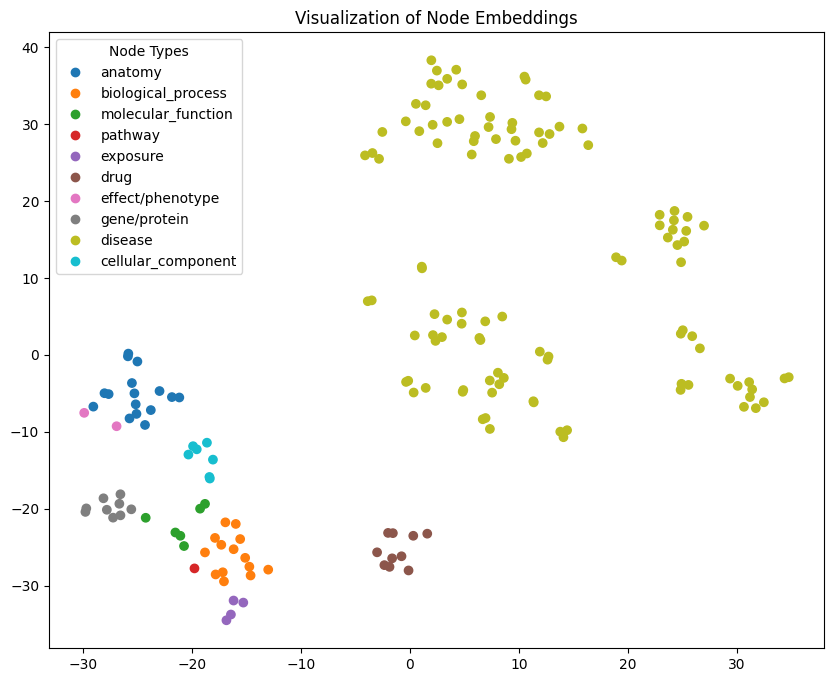

In [106]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=42, perplexity=10)  # trial and error, 15 seems to be the cut off
# Get the embeddings and labels
embeddings = np.array([node.embedding for node in subgraph_nodes])

reduced_embeddings = tsne.fit_transform(embeddings)
labels = [node.metadata['node_type'] for node in subgraph_nodes]

# Convert labels to numerical values for coloring
label_to_num = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = [label_to_num[label] for label in labels]

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='tab10')

# Add a legend on the side
legend_labels = list(label_to_num.keys())
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Types", loc="upper left")

# Add labels and title
plt.title("Visualization of Node Embeddings")
plt.show()

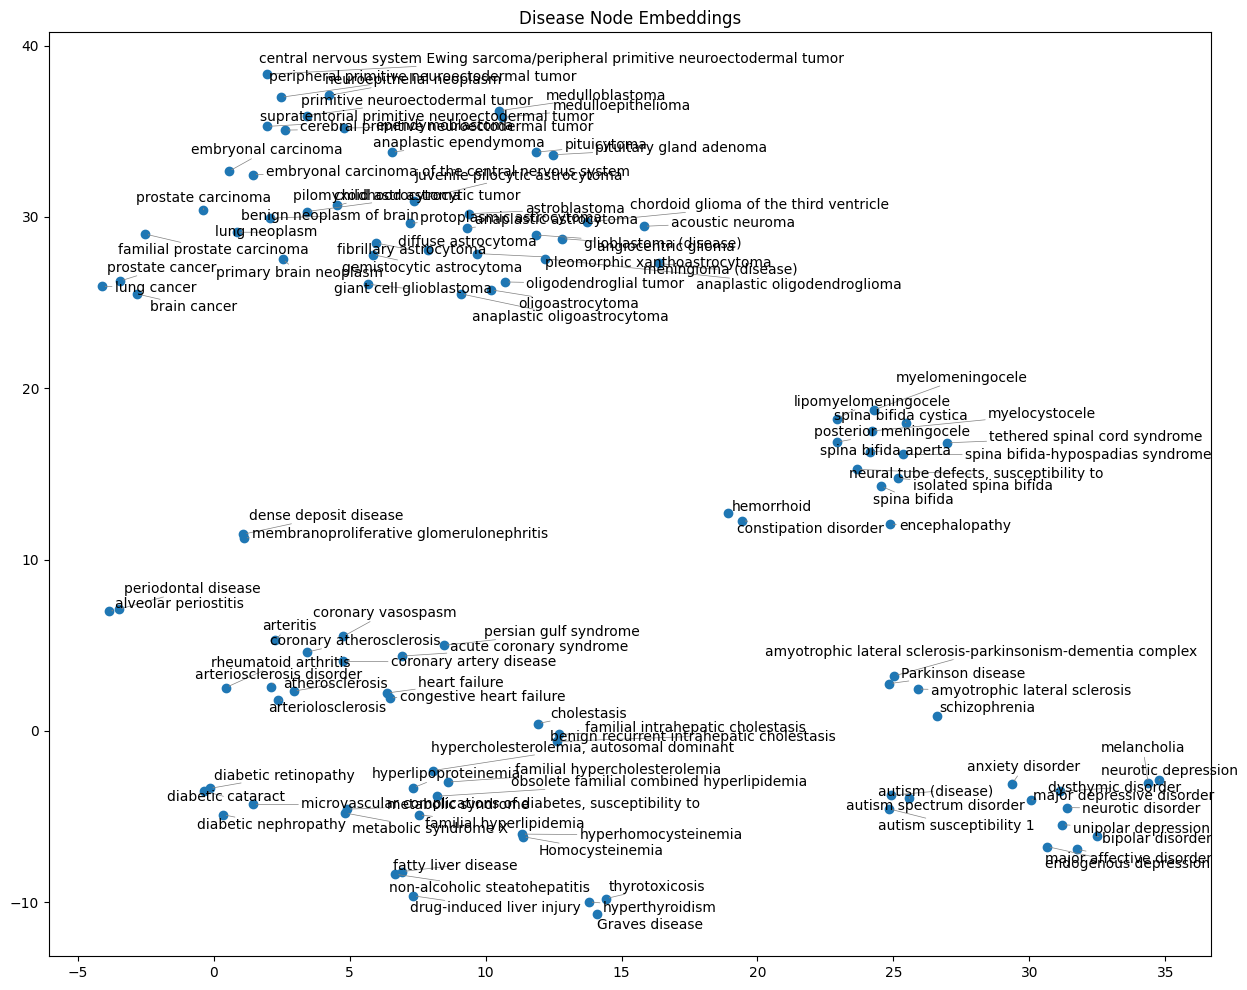

In [113]:
from adjustText import adjust_text  # Import the library for label adjustment

# Plot the embeddings according to the "node_type" = 'disease' from the "reduced_embeddings" variable
disease_embeddings = []
disease_labels = []
for i, node in enumerate(subgraph_nodes):
    if node.metadata['node_type'] == 'disease':
        disease_embeddings.append(reduced_embeddings[i])
        disease_labels.append(node.metadata['node_name'])

# Plot the embeddings
disease_embeddings = np.array(disease_embeddings)
plt.figure(figsize=(15, 12))  # Increase the figure size
plt.scatter(disease_embeddings[:, 0], disease_embeddings[:, 1])

# Add labels and adjust their positions
texts = []
for i, txt in enumerate(disease_labels):
    texts.append(plt.text(disease_embeddings[i, 0], disease_embeddings[i, 1], txt))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))  # Adjust text positions

plt.title("Disease Node Embeddings")
plt.show()

## Semantic similarity VS metric similarity

semantic similarity:
1. genenerate embeddings from the 'node_name', these embeddings should capture relationships among the terms grouping similar closer together.
2. calculate pairwise cosine similarity/Eucleidian distance
    - (both methods agree on the most similar pair, which corresponds to the same pair in the graph)

?? should I apply dimensionality reduction

In [181]:
#extract all `node_names` from the `index_nodes` variable for the nodes with the `node_type` = 'disease'
disease_names = []
for node in index_nodes:
    if node.metadata['node_type'] == 'disease':
        disease_names.append(node.metadata['node_name'])

disease_names

['parastremmatic dwarfism',
 'bone dysplasia',
 'TRPV4-related bone disorder',
 'annular epidermolytic ichthyosis',
 'epidermolytic ichthyosis']

In [220]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with a biomedical model if needed

# Compute embeddings for node names
node_embeddings = model.encode(disease_names)

similarity = cosine_similarity(node_embeddings, node_embeddings)
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_names[max_idx[0]], disease_names[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(node_embeddings, node_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = np.min(distance)
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_names[min_idx[0]], disease_names[min_idx[1]]))

Max cosine similarity: 0.93267953 ('annular epidermolytic ichthyosis', 'epidermolytic ichthyosis')
Min euclidean distance: 0.36693457 ('annular epidermolytic ichthyosis', 'epidermolytic ichthyosis')


embeddings from the index:

In [272]:
similarity = cosine_similarity(disease_embeddings, disease_embeddings) #direct from the dimensionality reduction
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_labels[max_idx[0]], disease_labels[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(disease_embeddings, disease_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = distance.min()
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_labels[min_idx[0]], disease_labels[min_idx[1]]))


Max cosine similarity: 0.98910624 ('parastremmatic dwarfism', 'epidermolytic ichthyosis')
Min euclidean distance: 2.1278055 ('bone dysplasia', 'TRPV4-related bone disorder')


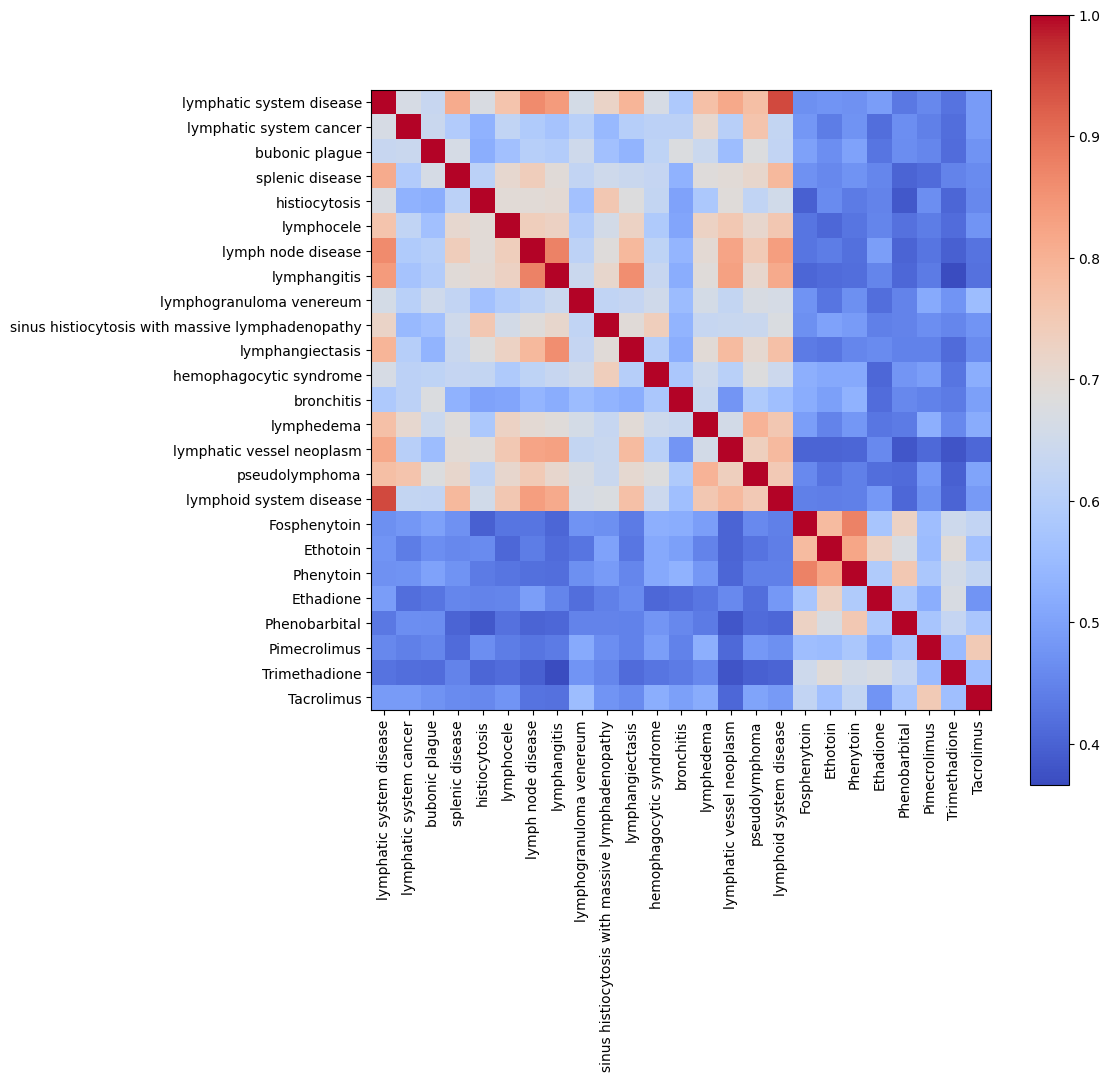

In [37]:
# calculate Pearson correlations among the embeddings in index_nodes
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

index_nodes_embeddings = np.array([node.embedding for node in index_nodes])
correlations = np.corrcoef(index_nodes_embeddings)

#plot half of the correlation matrix with labels and correlation values
plt.figure(figsize=(10, 10))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes], rotation=90)
plt.yticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes])
plt.show()



comparison of both:
-   between the distance from the 'node_name' and the distance from the index
- the distance value for the same pair should be similar: large distance for pairs distant in the index and in the 'node_name'